# Mixture-of-Experts IV Forecasting Model

**Objective**: Predict 5-day changes in ATM implied volatility (ΔIV) using a regime-aware MoE architecture.

**Key Design Choices**:
- Shared LSTM encoder with 3 expert heads (parameter-efficient)
- Gating based on last timestep features (current regime routing)
- Top-2 soft routing with load balancing loss
- Physics-based sample weighting (fit_cost, martingale_error, calendar violations)
- Stratified batching for multi-ticker balance
- Temporal train/val/test split (no lookahead)

## 1. Setup & Configuration

In [215]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
@dataclass
class Config:
    """Model and training configuration."""
    # Data
    seq_len: int = 10
    horizon: int = 10

    # Features
    feature_cols: Tuple[str, ...] = (
        'ATM_IV', 'ATM_skew', 'ATM_curvature', 'T',
        'total_var',
        'IV_percentile', 'IV_momentum', 'IV_acceleration',
        'skew_percentile', 'term_slope',
        'ATM_IV_zscore', 'ATM_skew_zscore',
        'total_var_change_lag1', 'total_var_change_lag2', 'total_var_change_lag3', 'total_var_change_lag5', 'total_var_change_lag7'
    )

    # Gating features (subset used for regime routing)
    gating_cols: Tuple[str, ...] = (
        'IV_percentile', 'IV_momentum',
        'ATM_IV_zscore', 'T', 'total_var_change_lag1'
    )

    # Model architecture
    hidden_dim: int = 96
    num_lstm_layers: int = 2
    num_experts: int = 4
    top_k: int = 2  # Number of experts to route to
    expert_hidden_dim: int = 64
    dropout: float = 0.3

    # Training
    batch_size: int = 256
    samples_per_ticker: int = 12  # For stratified batching
    learning_rate: float = 1e-3
    weight_decay: float = 3e-4
    max_epochs: int = 150        
    patience: int = 30           
    min_improvement: float = 0.001

    # Loss weights
    load_balance_weight: float = 0.2  
    momentum_weight: float =  0.1

    # Temporal split dates
    train_end: str = '2024-09-30'
    val_end: str = '2025-03-30'
    

    @property
    def input_dim(self) -> int:
        return len(self.feature_cols)

    @property
    def gating_dim(self) -> int:
        return len(self.gating_cols)

config = Config()
print(f"Input dim: {config.input_dim}")
print(f"Gating dim: {config.gating_dim}")

Input dim: 17
Gating dim: 5


## 2. Data Loading & Sequence Creation

In [217]:
def load_and_merge_data(svi_path: str, ssvi_path: str, rnd_path: str) -> pd.DataFrame:
    """
    Load and merge SVI, SSVI, and RND data.
    Returns DataFrame with physics-based weights.
    """
    # Load data
    df = pd.read_parquet(svi_path)
    ssvi = pd.read_parquet(ssvi_path)
    rnd = pd.read_parquet(rnd_path)

    # Ensure datetime
    for d in [df, ssvi, rnd]:
        d['asof'] = pd.to_datetime(d['asof'])
        d['expiry'] = pd.to_datetime(d['expiry'])

    # Merge physics columns
    df = df.merge(
        ssvi[['asof', 'expiry', 'fit_cost']],
        on=['asof', 'expiry'],
        how='left'
    )
    df = df.merge(
        rnd[['asof', 'expiry', 'martingale_error']],
        on=['asof', 'expiry'],
        how='left'
    )

    return df


def compute_physics_weights(df: pd.DataFrame, calendar_penalty: float = 0.05) -> pd.DataFrame:
    """
    Compute physics-based sample weights.

    Args:
        df: DataFrame with fit_cost, martingale_error columns
        calendar_penalty: Penalty for calendar violations (data-driven, ~5%)
    """
    df = df.copy()
    df = df.sort_values(['expiry', 'asof'])

    # Calendar violations: theta (approximated by 'a') should be monotone
    df['theta_violation'] = df.groupby('expiry')['a'].diff() < 0
    df['theta_violation'] = df['theta_violation'].fillna(False).astype(float)

    # Fill nulls
    df['fit_cost'] = df['fit_cost'].fillna(df['fit_cost'].median())
    df['martingale_error'] = df['martingale_error'].fillna(0.01)

    # Normalize components to [0, 1] (higher = better)
    fit_range = df['fit_cost'].max() - df['fit_cost'].min() + 1e-8
    fit_cost_norm = 1 - (df['fit_cost'] - df['fit_cost'].min()) / fit_range

    martingale_norm = 1 - df['martingale_error'].clip(0, 0.1) / 0.1

    calendar_norm = 1.0 - calendar_penalty * df['theta_violation']

    # Combined physics weight
    df['physics_weight'] = fit_cost_norm * martingale_norm * calendar_norm

    # Liquidity weight (prefer shorter-term, more liquid)
    df['liquidity_weight'] = 1.0 / (df['T'] + 0.1)

    # Final weight, normalized to mean=1
    df['sample_weight'] = df['physics_weight'] * df['liquidity_weight']
    df['sample_weight'] = df['sample_weight'] / df['sample_weight'].mean()

    return df

In [ ]:
def create_sequences(
    df: pd.DataFrame,
    feature_cols: List[str],
    gating_cols: List[str],
    seq_len: int = 10,
    horizon: int = 5
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:
    
    sequences = []
    gating_features = []
    targets = []
    weights = []
    metadata = []

    # Get column indices for gating features
    gating_indices = [feature_cols.index(c) for c in gating_cols if c in feature_cols]

    df_sorted = df.sort_values(['expiry', 'asof'])

    for expiry, group in df_sorted.groupby('expiry'):
        group = group.sort_values('asof').reset_index(drop=True)

        if len(group) < seq_len + horizon:
            continue

        features = group[list(feature_cols)].values

        for i in range(len(group) - seq_len - horizon + 1):
            seq = features[i:i + seq_len]

            # Target: IV change over horizon
            # Target: Total variance change over horizon
            current_iv = group.iloc[i + seq_len - 1]['ATM_IV']
            future_iv = group.iloc[i + seq_len + horizon - 1]['ATM_IV']
            current_T = group.iloc[i + seq_len - 1]['T']
            future_T = group.iloc[i + seq_len + horizon - 1]['T']

            # Total variance = IV² × T 
            current_total_var = (current_iv ** 2) * current_T
            future_total_var = (future_iv ** 2) * future_T
            target = future_total_var - current_total_var

            # Weight from last timestep
            weight = group.iloc[i + seq_len - 1]['sample_weight']

            # Gating features from last timestep
            gate_feat = seq[-1, gating_indices]

            # Metadata for stratification
            row = group.iloc[i + seq_len - 1]
            meta = {
      'ticker': row.get('ticker', 'UNKNOWN'),
      'asof': row['asof'],
      'asof_future': group.iloc[i + seq_len + horizon - 1]['asof'],  
      'expiry': expiry,

      #  maturities at t and t+h
      'T': float(current_T),
      'T_future': float(future_T),

      #  total variance at t and t+h (pre-normalisation)
      'total_var_t': float(current_total_var),
      'total_var_future': float(future_total_var),

      'T_bucket': 'near' if current_T < 0.08 else ('medium' if current_T < 0.15 else 'far')
  }


            sequences.append(seq)
            gating_features.append(gate_feat)
            targets.append(target)
            weights.append(weight)
            metadata.append(meta)

    X = np.array(sequences, dtype=np.float32)
    X_gate = np.array(gating_features, dtype=np.float32)
    y = np.array(targets, dtype=np.float32)
    w = np.array(weights, dtype=np.float32)
    meta_df = pd.DataFrame(metadata)

    return X, X_gate, y, w, meta_df

In [ ]:
def create_constant_maturity_sequences(
    df: pd.DataFrame,
    feature_cols: List[str],
    gating_cols: List[str],
    target_T: float = 0.08,  # ~30 days
    T_tolerance: float = 0.03,  # Accept 20-40 days
    seq_len: int = 10,
    horizon: int = 10
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:

    sequences = []
    gating_features = []
    targets = []
    weights = []
    metadata = []

    gating_indices = [list(feature_cols).index(c) for c in gating_cols if c in feature_cols]

    df = df.sort_values('asof')
    dates = sorted(df['asof'].unique())

    # For each date, find best expiry for target maturity
    date_to_row = {}
    for asof in dates:
        day_df = df[df['asof'] == asof].copy()

        # Find expiries within tolerance of target_T
        candidates = day_df[np.abs(day_df['T'] - target_T) <= T_tolerance]

        if len(candidates) == 0:
            continue

        # Pick the one closest to target_T
        best_idx = (candidates['T'] - target_T).abs().idxmin()
        date_to_row[asof] = candidates.loc[best_idx].copy()

    if len(date_to_row) < seq_len + horizon:
        print(f"Warning: Only {len(date_to_row)} dates for T={target_T}, need {seq_len + horizon}")
        return (np.array([]), np.array([]), np.array([]), np.array([]), pd.DataFrame())

    # Convert to DataFrame (index = asof dates), keep dates aligned after sorting
    cm_df = pd.DataFrame.from_dict(date_to_row, orient='index')
    cm_df.index = pd.to_datetime(cm_df.index)
    cm_df = cm_df.sort_index()
    cm_df['_date'] = cm_df.index  # <-- aligned, deterministic
    cm_df = cm_df.reset_index(drop=True)


    # Check for required columns
    missing = set(feature_cols) - set(cm_df.columns)
    if missing:
        raise ValueError(f"Missing feature columns: {missing}")

    features = cm_df[list(feature_cols)].values.astype(np.float32)

    # Handle NaN in features
    if np.isnan(features).any():
        print(f"Warning: {np.isnan(features).sum()} NaN values in features, forward-filling")
        features = pd.DataFrame(features).fillna(method='ffill').fillna(method='bfill').values

    for i in range(len(cm_df) - seq_len - horizon + 1):
        seq = features[i:i + seq_len]

        # Skip if sequence contains NaN
        if np.isnan(seq).any():
            continue

        current_iv = cm_df.iloc[i + seq_len - 1]['ATM_IV']
        future_iv = cm_df.iloc[i + seq_len + horizon - 1]['ATM_IV']
        current_T = cm_df.iloc[i + seq_len - 1]['T']
        future_T = cm_df.iloc[i + seq_len + horizon - 1]['T']

        # Total variance = IV² × T
        current_total_var = (current_iv ** 2) * current_T
        future_total_var = (future_iv ** 2) * future_T
        target = future_total_var - current_total_var

        # Skip if target is NaN
        if np.isnan(target):
            continue

        weight = cm_df.iloc[i + seq_len - 1].get('sample_weight', 1.0)
        if np.isnan(weight):
            weight = 1.0

        gate_feat = seq[-1, gating_indices]

        row_t = cm_df.iloc[i + seq_len - 1]
        row_f = cm_df.iloc[i + seq_len + horizon - 1]

        meta = {
            'ticker': row_t.get('ticker', 'UNKNOWN'),

            # true dates at t and t+h (trading-day aligned by construction of cm_df)
            'asof': row_t['_date'],
            'asof_future': row_f['_date'],

            # expiries can change in constant-maturity construction; keep both
            'expiry': row_t['expiry'],
            'expiry_future': row_f['expiry'],

            # TRUE maturities at t and t+h
            'T': float(current_T),
            'T_future': float(future_T),

            # TRUE total variance at t and t+h (pre-normalisation)
            'total_var_t': float(current_total_var),
            'total_var_future': float(future_total_var),

            'target_T': float(target_T),
        }


        sequences.append(seq)
        gating_features.append(gate_feat)
        targets.append(target)
        weights.append(weight)
        metadata.append(meta)

    print(f"Created {len(sequences)} sequences for T≈{target_T:.2f} ({target_T*365:.0f}d)")

    return (
        np.array(sequences, dtype=np.float32),
        np.array(gating_features, dtype=np.float32),
        np.array(targets, dtype=np.float32),
        np.array(weights, dtype=np.float32),
        pd.DataFrame(metadata)
    )


def create_multi_maturity_sequences(
    df: pd.DataFrame,
    feature_cols: List[str],
    gating_cols: List[str],
    maturity_targets: List[Tuple[float, float]] = None,  # [(target_T, tolerance), ...]
    seq_len: int = 10,
    horizon: int = 5
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:
    
    if maturity_targets is None:
        maturity_targets = [
            (0.08, 0.03),   # ~30 days (20-40 day window)
            (0.16, 0.04),   # ~60 days (45-75 day window)
            (0.25, 0.05),   # ~90 days (70-110 day window)
        ]

    all_X = []
    all_X_gate = []
    all_y = []
    all_w = []
    all_meta = []

    for target_T, tolerance in maturity_targets:
        X, X_gate, y, w, meta = create_constant_maturity_sequences(
            df, feature_cols, gating_cols,
            target_T=target_T,
            T_tolerance=tolerance,
            seq_len=seq_len,
            horizon=horizon
        )

        if len(X) > 0:
            all_X.append(X)
            all_X_gate.append(X_gate)
            all_y.append(y)
            all_w.append(w)
            all_meta.append(meta)

    if not all_X:
        return (np.array([]), np.array([]), np.array([]), np.array([]), pd.DataFrame())

    return (
        np.concatenate(all_X),
        np.concatenate(all_X_gate),
        np.concatenate(all_y),
        np.concatenate(all_w),
        pd.concat(all_meta, ignore_index=True)
    )

In [220]:
def temporal_split(
    X: np.ndarray,
    X_gate: np.ndarray,
    y: np.ndarray,
    w: np.ndarray,
    meta: pd.DataFrame,
    train_end: pd.Timestamp,
    val_end: pd.Timestamp
) -> Dict[str, Tuple[np.ndarray, ...]]:
    """
    Temporal split with explicit date boundaries.
    """
    train_mask = meta['asof'] <= train_end
    val_mask = (meta['asof'] > train_end) & (meta['asof'] <= val_end)
    test_mask = meta['asof'] > val_end

    splits = {}
    for name, mask in [('train', train_mask), ('val', val_mask), ('test', test_mask)]:
        idx = mask.values
        splits[name] = (
            X[idx], X_gate[idx], y[idx], w[idx], meta[mask].reset_index(drop=True)
        )
        print(f"{name}: {idx.sum()} samples")

    return splits

In [ ]:
import numpy as np

def sigma_persistence_delta(meta_df, eps=1e-12):
    """
    Proper σ-persistence baseline for your target y = Δw where w = σ²T.

    Holds σ² constant at time t:
      σ²_t = w_t / T_t
      ŵ_{t+h} = σ²_t * T_{t+h}
      Δŵ = ŵ_{t+h} - w_t
    """
    required = {'T', 'T_future', 'total_var_t'}
    missing = required - set(meta_df.columns)
    if missing:
        raise ValueError(
            f"meta_df missing columns {missing}. "
            
        )

    T_t = meta_df['T'].to_numpy(dtype=np.float64)
    T_f = meta_df['T_future'].to_numpy(dtype=np.float64)
    w_t = meta_df['total_var_t'].to_numpy(dtype=np.float64)

    T_t = np.maximum(T_t, eps)
    T_f = np.maximum(T_f, eps)  # guard against any data issues

    w_hat_f = (w_t / T_t) * T_f
    delta_hat = w_hat_f - w_t
    return delta_hat.astype(np.float32)

def metrics(y_true, y_pred, sample_weight=None):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    err = y_pred - y_true

    out = {
        "mae": float(np.mean(np.abs(err))),
        "rmse": float(np.sqrt(np.mean(err**2))),
    }

    if sample_weight is not None:
        sw = np.asarray(sample_weight, dtype=np.float64)
        sw = np.clip(sw, 0.0, np.inf)
        denom = sw.sum()
        out["w_mae"] = float((sw * np.abs(err)).sum() / denom) if denom > 0 else float("nan")
        out["w_rmse"] = float(np.sqrt((sw * (err**2)).sum() / denom)) if denom > 0 else float("nan")

    return out


In [222]:
class RollingNormalizer:
    """
    Fit normalization on training data, apply to val/test.
    Avoids lookahead bias.
    """
    def __init__(self):
        self.mean = None
        self.std = None
        self.gate_mean = None
        self.gate_std = None

    def fit(self, X: np.ndarray, X_gate: np.ndarray):
        """Fit on training data."""
        # Flatten sequences for stats: (n_samples * seq_len, n_features)
        X_flat = X.reshape(-1, X.shape[-1])
        self.mean = X_flat.mean(axis=0)
        self.std = X_flat.std(axis=0) + 1e-8

        self.gate_mean = X_gate.mean(axis=0)
        self.gate_std = X_gate.std(axis=0) + 1e-8
        return self

    def transform(self, X: np.ndarray, X_gate: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Apply normalization."""
        X_norm = (X - self.mean) / self.std
        X_gate_norm = (X_gate - self.gate_mean) / self.gate_std
        return X_norm.astype(np.float32), X_gate_norm.astype(np.float32)

    def fit_transform(self, X: np.ndarray, X_gate: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        self.fit(X, X_gate)
        return self.transform(X, X_gate)

## 3. Stratified Batch Sampler

In [223]:
class StratifiedBatchSampler(Sampler):
    """
    Yields batches with equal representation per ticker.
    Ensures no single ticker dominates any gradient update.
    """

    def __init__(
        self,
        ticker_indices: Dict[str, List[int]],
        samples_per_ticker: int,
        drop_last: bool = True,
        shuffle: bool = True
    ):
        """
        Args:
            ticker_indices: Dict mapping ticker -> list of sample indices
            samples_per_ticker: Number of samples per ticker per batch
            drop_last: Drop incomplete batches
            shuffle: Shuffle within each ticker
        """
        self.ticker_indices = ticker_indices
        self.samples_per_ticker = samples_per_ticker
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.tickers = list(ticker_indices.keys())

    def __iter__(self):
        # Shuffle within each ticker
        if self.shuffle:
            shuffled = {
                t: np.random.permutation(idx).tolist()
                for t, idx in self.ticker_indices.items()
            }
        else:
            shuffled = {t: list(idx) for t, idx in self.ticker_indices.items()}

        # Yield batches with samples_per_ticker from each ticker
        while True:
            # Check if all tickers have enough samples
            if not all(len(idx) >= self.samples_per_ticker for idx in shuffled.values()):
                if not self.drop_last:
                    # Yield remaining samples
                    remaining = []
                    for idx_list in shuffled.values():
                        remaining.extend(idx_list)
                    if remaining:
                        yield remaining
                break

            batch = []
            for ticker in self.tickers:
                for _ in range(self.samples_per_ticker):
                    batch.append(shuffled[ticker].pop())

            # Shuffle batch to mix tickers
            if self.shuffle:
                np.random.shuffle(batch)

            yield batch

    def __len__(self):
        min_samples = min(len(idx) for idx in self.ticker_indices.values())
        return min_samples // self.samples_per_ticker


def build_ticker_indices(meta: pd.DataFrame) -> Dict[str, List[int]]:
    """Build ticker -> indices mapping for stratified sampling."""
    indices = defaultdict(list)
    for i, ticker in enumerate(meta['ticker']):
        indices[ticker].append(i)
    return dict(indices)

## 4. Dataset

In [224]:
class IVDataset(Dataset):
    """Dataset for IV forecasting with MoE."""

    def __init__(
        self,
        X: np.ndarray,
        X_gate: np.ndarray,
        y: np.ndarray,
        w: np.ndarray
    ):
        self.X = torch.from_numpy(X).float()
        self.X_gate = torch.from_numpy(X_gate).float()
        self.y = torch.from_numpy(y).float()
        self.w = torch.from_numpy(w).float()

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, ...]:
        return self.X[idx], self.X_gate[idx], self.y[idx], self.w[idx]

## 5. MoE Model Architecture

In [225]:
class GatingNetwork(nn.Module):
    """
    Routes samples to experts based on current regime features.
    Uses last timestep features for interpretable routing.
    """

    def __init__(self, input_dim: int, num_experts: int, hidden_dim: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, num_experts)
        )
        self.num_experts = num_experts

    def forward(self, x: torch.Tensor, top_k: int = 2) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: (batch, gating_dim) - gating features
            top_k: number of experts to route to

        Returns:
            weights: (batch, num_experts) - sparse weights (only top_k non-zero)
            load: (num_experts,) - fraction of samples routed to each expert
        """
        logits = self.net(x)  # (batch, num_experts)

        # Top-k selection
        top_k_logits, top_k_indices = torch.topk(logits, top_k, dim=-1)
        top_k_weights = F.softmax(top_k_logits, dim=-1)  # (batch, top_k)

        # Scatter to full weight matrix
        weights = torch.zeros_like(logits)
        weights.scatter_(1, top_k_indices, top_k_weights)

        # Compute load for balancing loss
        # Load = average probability mass assigned to each expert
        load = weights.mean(dim=0)  # (num_experts,)

        return weights, load

In [226]:
class ExpertHead(nn.Module):
    """Single expert prediction head."""

    def __init__(self, input_dim: int, hidden_dim: int = 32, dropout: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x).squeeze(-1)  # (batch,)

In [227]:
class MoEIVForecaster(nn.Module):
    """
    Mixture-of-Experts model for IV forecasting.

    Architecture:
        Input sequences -> Shared LSTM encoder -> Hidden representation
        Gating features -> Gating network -> Expert weights
        Hidden + Weights -> Expert heads -> Weighted prediction
    """

    def __init__(self, config: Config):
        super().__init__()
        self.config = config

        # Shared LSTM encoder
        self.encoder = nn.LSTM(
            input_size=config.input_dim,
            hidden_size=config.hidden_dim,
            num_layers=config.num_lstm_layers,
            batch_first=True,
            dropout=config.dropout if config.num_lstm_layers > 1 else 0.0,
            bidirectional=False
        )

        # Gating network (routes based on regime features)
        self.gating = GatingNetwork(
            input_dim=config.gating_dim,
            num_experts=config.num_experts,
            hidden_dim=32
        )

        # Expert heads
        self.experts = nn.ModuleList([
            ExpertHead(
                input_dim=config.hidden_dim,
                hidden_dim=config.expert_hidden_dim,
                dropout=config.dropout
            )
            for _ in range(config.num_experts)
        ])

    def forward(
        self,
        x: torch.Tensor,
        x_gate: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            x: (batch, seq_len, input_dim) - input sequences
            x_gate: (batch, gating_dim) - gating features (last timestep)

        Returns:
            pred: (batch,) - final predictions
            weights: (batch, num_experts) - expert weights
            load: (num_experts,) - load per expert (for balancing)
        """
        # Encode sequence
        lstm_out, (h_n, c_n) = self.encoder(x)
        # Use last hidden state from top layer
        hidden = h_n[-1]  # (batch, hidden_dim)

        # Get expert weights from gating network
        weights, load = self.gating(x_gate, top_k=self.config.top_k)

        # Get predictions from each expert
        expert_preds = torch.stack(
            [expert(hidden) for expert in self.experts],
            dim=1
        )  # (batch, num_experts)

        # Weighted combination
        pred = (weights * expert_preds).sum(dim=1)  # (batch,)

        return pred, weights, load

    def get_expert_predictions(self, x: torch.Tensor, x_gate: torch.Tensor) -> torch.Tensor:
        """Get individual expert predictions (for analysis)."""
        lstm_out, (h_n, c_n) = self.encoder(x)
        hidden = h_n[-1]
        expert_preds = torch.stack(
            [expert(hidden) for expert in self.experts],
            dim=1
        )
        return expert_preds

## 6. Loss Function

In [ ]:
class MoELoss(nn.Module):
    """
    Combined loss for MoE model:
    1. Weighted MSE on predictions
    2. Load balancing penalty (encourages even expert usage)
    3. Momentum consistency penalty (encourages predictions to respect recent dynamics)
    """

    def __init__(
        self,
        num_experts: int,
        load_balance_weight: float = 0.1,
        momentum_weight: float = 0.05
    ):
        super().__init__()
        self.num_experts = num_experts
        self.load_balance_weight = load_balance_weight
        self.momentum_weight = momentum_weight

    def forward(
        self,
        pred: torch.Tensor,           # (batch_size,) predictions
        target: torch.Tensor,          # (batch_size,) targets
        expert_weights: torch.Tensor,  # (batch_size, num_experts) gating weights
        sample_weights: torch.Tensor,  # (batch_size,) sample importance weights
        load: torch.Tensor,            # (num_experts,) expert load from gating
        lag1_features: torch.Tensor = None  # (batch_size,) lag-1 variance changes
    ) -> tuple[torch.Tensor, dict]:
        """
        Compute combined loss and return metrics.

        Args:
            pred: Model predictions
            target: Ground truth targets
            expert_weights: Routing weights from gating network
            sample_weights: Physics-based sample weights
            load: Expert load scores for balancing
            lag1_features: Recent variance changes (for momentum penalty)

        Returns:
            total_loss: Combined weighted loss
            metrics: Dict of loss components for logging
        """
        batch_size = pred.shape[0]
        metrics = {}

        # 1. Weighted MSE Loss
        squared_errors = (pred - target) ** 2
        weighted_mse = (squared_errors * sample_weights).sum() / sample_weights.sum()
        metrics['mse'] = weighted_mse.item()

        # 2. Load Balancing Loss
        # Encourage even distribution of expert usage
        # Penalize when load deviates from uniform (1/num_experts)
        uniform_load = 1.0 / self.num_experts
        load_variance = ((load - uniform_load) ** 2).mean()
        metrics['load_balance'] = load_variance.item()

        # 3. Momentum Consistency Loss (NEW)
        momentum_loss = torch.tensor(0.0, device=pred.device)
        if lag1_features is not None and self.momentum_weight > 0:
           
            pred_normalized = pred / (pred.std() + 1e-8)
            lag1_normalized = lag1_features / (lag1_features.std() + 1e-8)
            correlation = (pred_normalized * lag1_normalized).mean()
            
            momentum_loss = torch.relu(correlation)  # Penalize positive correlation

            metrics['momentum_loss'] = momentum_loss.item()
            metrics['pred_lag1_corr'] = correlation.item()

        # Total Loss
        total_loss = (
            weighted_mse +
            self.load_balance_weight * load_variance +
            self.momentum_weight * momentum_loss
        )

        metrics['total_loss'] = total_loss.item()

        return total_loss, metrics

## 7. Training Loop

In [ ]:
class Trainer:
    """Training orchestrator with early stopping and metrics tracking."""

    def __init__(
        self,
        model: MoEIVForecaster,
        config: Config,
        device: torch.device
    ):
        self.model = model.to(device)
        self.config = config
        self.device = device

        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )

        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',  
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        self.criterion = MoELoss(
            num_experts=config.num_experts,
            load_balance_weight=config.load_balance_weight
        )

        self.history = defaultdict(list)

    def train_epoch(self, dataloader: DataLoader) -> Dict[str, float]:
        
        self.model.train()
        epoch_metrics = defaultdict(float)
        n_batches = 0

        lag1_idx = list(self.config.feature_cols).index('total_var_change_lag1')

        for X, X_gate, y, w in dataloader:
            X = X.to(self.device)
            X_gate = X_gate.to(self.device)
            y = y.to(self.device)
            w = w.to(self.device)

            self.optimizer.zero_grad()

            pred, weights, load = self.model(X, X_gate)
            lag1_features = X[:, -1, lag1_idx]
            loss, metrics = self.criterion(pred, y, weights, w, load, lag1_features)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            for k, v in metrics.items():
                epoch_metrics[k] += v
            n_batches += 1

        return {k: v / n_batches for k, v in epoch_metrics.items()}

    @torch.no_grad()
    def evaluate(self, dataloader: DataLoader) -> Dict[str, float]:
        """Evaluate on validation/test set."""
        self.model.eval()
        epoch_metrics = defaultdict(float)
        all_preds = []
        all_targets = []
        all_weights = []
        n_batches = 0

        lag1_idx = list(self.config.feature_cols).index('total_var_change_lag1')

        for X, X_gate, y, w in dataloader:
            X = X.to(self.device)
            X_gate = X_gate.to(self.device)
            y = y.to(self.device)
            w = w.to(self.device)

            pred, weights, load = self.model(X, X_gate)
            lag1_features = X[:, -1, lag1_idx]

            loss, metrics = self.criterion(pred, y, weights, w, load, lag1_features)

            for k, v in metrics.items():
                epoch_metrics[k] += v

            all_preds.append(pred.cpu())
            all_targets.append(y.cpu())
            all_weights.append(weights.cpu())
            n_batches += 1

        metrics = {k: v / n_batches for k, v in epoch_metrics.items()}

        # Additional metrics
        preds = torch.cat(all_preds).numpy()
        targets = torch.cat(all_targets).numpy()

        metrics['mae'] = np.abs(preds - targets).mean()
        metrics['rmse'] = np.sqrt(((preds - targets) ** 2).mean())

        direction_correct = ((preds > 0) == (targets > 0)).astype(float)
        metrics['direction_accuracy'] = float(direction_correct.mean())

        # Naive baseline: predict 0 (no change)
        naive_mae = np.abs(targets).mean()
        metrics['skill_vs_naive'] = 1 - metrics['mae'] / naive_mae

        # Expert usage
        weights = torch.cat(all_weights).numpy()
        metrics['expert_usage'] = weights.mean(axis=0).tolist()

        return metrics

    def fit(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader
    ) -> Dict[str, list]:
        """Full training loop with early stopping."""
        best_val_skill = -float('inf')  
        best_state = None
        patience_counter = 0

        for epoch in range(1, self.config.max_epochs + 1):
            train_metrics = self.train_epoch(train_loader)
            val_metrics = self.evaluate(val_loader)

            # Update scheduler 
            self.scheduler.step(val_metrics['skill_vs_naive'])  

            # Track history
            for k, v in train_metrics.items():
                self.history[f'train_{k}'].append(v)
            for k, v in val_metrics.items():
                if isinstance(v, (int, float)):
                    self.history[f'val_{k}'].append(v)
            self.history['expert_usage'].append(val_metrics['expert_usage'])

            # Logging
            if epoch % 5 == 0 or epoch == 1:
                print(f"Epoch {epoch:3d} | "
                      f"Train MSE: {train_metrics['mse']:.6f} | "
                      f"Val MSE: {val_metrics['mse']:.6f} | "
                      f"Val MAE: {val_metrics['mae']:.6f} | "
                      f"Skill: {val_metrics['skill_vs_naive']:.3f} | "
                      f"Experts: {[f'{u:.2f}' for u in val_metrics['expert_usage']]}")

            # Early stopping based on skill improvement
            min_improvement = getattr(self.config, 'min_improvement', 1e-4)

            
            if val_metrics['skill_vs_naive'] > best_val_skill + min_improvement:
                best_val_skill = val_metrics['skill_vs_naive']
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
                patience_counter = 0

                # print when we find a better model
                if epoch > 1:
                    print(f"  → New best skill: {best_val_skill:.3f}")
            else:
                patience_counter += 1
                if patience_counter >= self.config.patience:
                    print(f"\nEarly stopping at epoch {epoch}")
                    print(f"Best validation skill: {best_val_skill:.3f}")
                    break

        # Restore best model
        if best_state is not None:
            self.model.load_state_dict(best_state)
            print(f"Restored best model (val_skill: {best_val_skill:.3f})")
        else:
            print("Warning: No improvement over baseline. Model may not be learning.")

        return dict(self.history)

## 8. Visualization & Analysis

In [230]:
def plot_training_history(history: Dict[str, list]):
    """Plot training curves."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Loss curves
    ax = axes[0, 0]
    ax.plot(history['train_mse'], label='Train MSE')
    ax.plot(history['val_mse'], label='Val MSE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.set_title('Loss Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Train vs Val MSE ratio (overfitting indicator)
    ax = axes[0, 1]
    train_mse = np.array(history['train_mse'])
    val_mse = np.array(history['val_mse'])
    ax.plot(val_mse / train_mse, label='Val/Train MSE Ratio')
    ax.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='No overfit')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Ratio')
    ax.set_title('Overfitting Indicator (lower=overfit)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Expert usage over time
    ax = axes[1, 0]
    expert_usage = np.array(history['expert_usage'])
    for i in range(expert_usage.shape[1]):
        ax.plot(expert_usage[:, i], label=f'Expert {i+1}')
    ax.axhline(y=1/expert_usage.shape[1], color='gray', linestyle='--', alpha=0.5, label='Ideal')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Usage Fraction')
    ax.set_title('Expert Usage Over Training')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Load balance loss
    ax = axes[1, 1]
    ax.plot(history['train_load_balance'], label='Train')
    ax.plot(history['val_load_balance'], label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Load Balance Loss')
    ax.set_title('Load Balancing')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
@torch.no_grad()
def analyze_expert_specialization(
    model: MoEIVForecaster,
    dataloader: DataLoader,
    meta: pd.DataFrame,
    device: torch.device
):
    """
    Analyze what regimes each expert specializes in.
    
    """
    model.eval()

    all_weights = []
    all_gate_features = []

    for X, X_gate, y, w in dataloader:
        X = X.to(device)
        X_gate = X_gate.to(device)

        _, weights, _ = model(X, X_gate)
        all_weights.append(weights.cpu().numpy())
        all_gate_features.append(X_gate.cpu().numpy())

    weights = np.concatenate(all_weights)
    gate_features = np.concatenate(all_gate_features)

    # Assign each sample to dominant expert
    dominant_expert = weights.argmax(axis=1)

    # Analyze gating features by expert
    gating_cols = list(config.gating_cols)

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, col in enumerate(gating_cols[:5]):
        ax = axes[i]
        for expert_id in range(config.num_experts):
            mask = dominant_expert == expert_id
            ax.hist(gate_features[mask, i], bins=30, alpha=0.5,
                   label=f'Expert {expert_id+1}', density=True)
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.set_title(f'{col} by Expert')
        ax.legend()

    # Summary stats
    ax = axes[5]
    expert_counts = [np.sum(dominant_expert == i) for i in range(config.num_experts)]
    ax.bar(range(config.num_experts), expert_counts)
    ax.set_xlabel('Expert')
    ax.set_ylabel('Sample Count')
    ax.set_title('Samples per Expert')
    ax.set_xticks(range(config.num_experts))
    ax.set_xticklabels([f'Expert {i+1}' for i in range(config.num_experts)])

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n" + "="*60)
    print("EXPERT SPECIALIZATION ANALYSIS")
    print("="*60)

    for expert_id in range(config.num_experts):
        mask = dominant_expert == expert_id
        print(f"\nExpert {expert_id + 1} ({mask.sum()} samples, {mask.mean()*100:.1f}%):")
        for j, col in enumerate(gating_cols):
            mean_val = gate_features[mask, j].mean()
            std_val = gate_features[mask, j].std()
            print(f"  {col:20s}: {mean_val:+.3f} ± {std_val:.3f}")

## 9. Main Execution

In [ ]:
# ============================================================
# MULTI-TICKER DATA LOADING
# ============================================================

# Define your tickers and file paths
TICKERS = [
    'AAPL', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'AMGN', 'AMZN',
    'ANET', 'AVGO', 'AXP', 'BA', 'BAC', 'BIIB', 'BKNG', 'BLK', 'CAT',
    'CHTR', 'CI', 'CMG', 'COST', 'CRM', 'DE', 'DG', 'DIA', 'DPZ', 'FDX',
    'GD', 'GOOG', 'GS', 'HD', 'HON', 'HSY', 'HUM', 'IBM', 'ILMN', 'INTU',
    'ISRG', 'JPM', 'KLAC', 'KRE', 'LLY', 'LMT', 'LOW', 'LRCX', 'MA',
    'MAR', 'MCD', 'MCK', 'MSFT', 'NFLT', 'NOC', 'NOW', 'NSC', 'NVDA',
    'REGN', 'RH', 'SPGI', 'SPY', 'STZ', 'TMO', 'TSCO', 'TXN', 'ULTA',
    'UNH', 'UNP', 'URI', 'V', 'VRTX', 'XBI', 'XLE', 'XLF', 'XLK',
    'XLY', 'XOP', 'XRT'
]

def get_file_paths(ticker: str, base_dir: str = '/content') -> Dict[str, str]:
    """
    
    """
    import glob

    paths = {}

    # SVI enriched: historical_svi_{TICKER}_*_enriched.parquet
    svi_matches = glob.glob(f"{base_dir}/historical_svi_{ticker}_*_enriched.parquet")
    if svi_matches:
        paths['svi'] = sorted(svi_matches)[-1]  # Most recent by filename

    # SSVI: historical_ssvi_{TICKER}_*.parquet (exclude 'enriched')
    ssvi_matches = [f for f in glob.glob(f"{base_dir}/historical_ssvi_{ticker}_*.parquet")
                    if 'enriched' not in f]
    if ssvi_matches:
        paths['ssvi'] = sorted(ssvi_matches)[-1]

    # RND: historical_rnd_{TICKER}_*.parquet (exclude 'enriched')
    rnd_matches = [f for f in glob.glob(f"{base_dir}/historical_rnd_{ticker}_*.parquet")
                   if 'enriched' not in f]
    if rnd_matches:
        paths['rnd'] = sorted(rnd_matches)[-1]

    return paths


def detect_available_tickers(base_dir: str = '/content') -> List[str]:
    """
    Auto-detect tickers that have all 3 required files.
    """
    import glob
    from collections import defaultdict

    ticker_files = defaultdict(set)

    # Find all SVI enriched files
    for f in glob.glob(f"{base_dir}/historical_svi_*_enriched.parquet"):
        # Extract ticker: historical_svi_{TICKER}_{date}_{time}_enriched.parquet
        parts = f.split('/')[-1].replace('.parquet', '').split('_')
        # parts = ['historical', 'svi', '{TICKER}', '{date}', '{time}', 'enriched']
        if len(parts) >= 4:
            ticker = parts[2]
            ticker_files[ticker].add('svi')

    # Find all SSVI files
    for f in glob.glob(f"{base_dir}/historical_ssvi_*.parquet"):
        if 'enriched' in f:
            continue
        parts = f.split('/')[-1].replace('.parquet', '').split('_')
        # parts = ['historical', 'ssvi', '{TICKER}', '{date}', '{time}']
        if len(parts) >= 4:
            ticker = parts[2]
            ticker_files[ticker].add('ssvi')

    # Find all RND files
    for f in glob.glob(f"{base_dir}/historical_rnd_*.parquet"):
        if 'enriched' in f:
            continue
        parts = f.split('/')[-1].replace('.parquet', '').split('_')
        if len(parts) >= 4:
            ticker = parts[2]
            ticker_files[ticker].add('rnd')

    # Return tickers with all 3 file types
    complete = [t for t, files in ticker_files.items() if files == {'svi', 'ssvi', 'rnd'}]

    print(f"Found {len(ticker_files)} tickers total:")
    for ticker, files in sorted(ticker_files.items()):
        status = "✅" if len(files) == 3 else f"❌ missing {set(['svi','ssvi','rnd']) - files}"
        print(f"  {ticker}: {status}")

    return sorted(complete)

def load_multi_ticker_data(
    tickers: List[str],
    base_dir: str = '/content',
    verbose: bool = True
) -> pd.DataFrame:
    """
    Load and merge data for multiple tickers.

    
    """
    df_list = []
    loaded_tickers = []
    failed_tickers = []

    for ticker in tickers:
        try:
            paths = get_file_paths(ticker, base_dir)

            # Check all required files exist
            required = ['svi', 'ssvi', 'rnd']
            missing = [k for k in required if k not in paths]

            if missing:
                if verbose:
                    print(f"  ⚠️  {ticker}: Missing files for {missing}")
                failed_tickers.append((ticker, f"Missing: {missing}"))
                continue

            if verbose:
                print(f"  📂 {ticker}: Loading...")

            # Load and merge
            df_ticker = load_and_merge_data(
                paths['svi'],
                paths['ssvi'],
                paths['rnd']
            )

            # Add ticker column
            df_ticker['ticker'] = ticker

            # Compute physics weights per ticker
            df_ticker = compute_physics_weights(df_ticker, calendar_penalty=0.05)

            df_list.append(df_ticker)
            loaded_tickers.append(ticker)

            if verbose:
                date_range = f"{df_ticker['asof'].min().date()} to {df_ticker['asof'].max().date()}"
                print(f"       ✅ {len(df_ticker):,} records | {date_range}")

        except Exception as e:
            if verbose:
                print(f"  ❌ {ticker}: Error - {str(e)[:50]}")
            failed_tickers.append((ticker, str(e)))
            continue

    if not df_list:
        raise ValueError("No tickers loaded successfully!")

    # Combine all tickers
    df_combined = pd.concat(df_list, ignore_index=True)

    # Summary
    print(f"\n{'='*60}")
    print(f"MULTI-TICKER LOAD SUMMARY")
    print(f"{'='*60}")
    print(f"Successfully loaded: {len(loaded_tickers)}/{len(tickers)} tickers")
    print(f"Tickers: {loaded_tickers}")
    print(f"Total records: {len(df_combined):,}")
    print(f"Date range: {df_combined['asof'].min().date()} to {df_combined['asof'].max().date()}")

    if failed_tickers:
        print(f"\nFailed tickers:")
        for ticker, reason in failed_tickers:
            print(f"  - {ticker}: {reason[:60]}")

    # Per-ticker summary
    print(f"\nPer-ticker breakdown:")
    ticker_summary = df_combined.groupby('ticker').agg({
        'asof': ['min', 'max', 'count']
    }).round(2)
    ticker_summary.columns = ['start', 'end', 'records']
    print(ticker_summary.to_string())

    return df_combined
# ============================================================
# AUTO-DETECT AND LOAD
# ============================================================

print("Detecting available tickers...\n")
TICKERS = detect_available_tickers('/content')

print(f"\n{'='*60}")
print(f"Using tickers: {TICKERS}")
print(f"{'='*60}\n")

if not TICKERS:
    raise ValueError("No complete tickers found!")

df = load_multi_ticker_data(TICKERS, base_dir='/content', verbose=True)
df['total_var'] = (df['ATM_IV'] ** 2) * df['T']
# 2. Add lagged variance changes as features
df = df.sort_values(['ticker', 'expiry', 'asof']).reset_index(drop=True)

for lag in [1, 2, 3, 5, 7]:
    # Compute lagged total variance changes
    # Group by ticker AND expiry to avoid mixing different contracts
    df[f'total_var_change_lag{lag}'] = (
        df.groupby(['ticker', 'expiry'])['total_var']
        .diff(lag)
        .fillna(0)  # Fill first few rows with 0
    )

print(f"Added lagged features: total_var_change_lag1, lag2, lag3")

Detecting available tickers...

Found 77 tickers total:
  AAPL: ✅
  ACN: ✅
  ADBE: ✅
  ADI: ✅
  ADP: ✅
  ADSK: ✅
  ALGN: ✅
  AMGN: ✅
  AMZN: ✅
  ANET: ✅
  AVGO: ✅
  AXP: ✅
  BA: ✅
  BAC: ✅
  BIIB: ✅
  BKNG: ✅
  BLK: ✅
  CAT: ✅
  CHTR: ✅
  CI: ✅
  CMG: ✅
  COST: ✅
  CRM: ✅
  DE: ✅
  DG: ✅
  DIA: ✅
  DPZ: ✅
  FDX: ✅
  GD: ✅
  GOOG: ✅
  GS: ✅
  HD: ✅
  HON: ✅
  HSY: ✅
  HUM: ✅
  IBM: ✅
  ILMN: ✅
  INTU: ✅
  ISRG: ✅
  JPM: ✅
  KLAC: ✅
  KRE: ✅
  LLY: ✅
  LMT: ✅
  LOW: ✅
  LRCX: ✅
  MA: ✅
  MAR: ✅
  MCD: ✅
  MCK: ✅
  MSFT: ✅
  NFLT: ✅
  NOC: ✅
  NOW: ✅
  NSC: ✅
  NVDA: ✅
  REGN: ✅
  RH: ✅
  SPGI: ✅
  SPY: ✅
  STZ: ✅
  TMO: ✅
  TSCO: ✅
  TXN: ✅
  ULTA: ✅
  UNH: ✅
  UNP: ✅
  URI: ✅
  V: ✅
  VRTX: ✅
  XBI: ✅
  XLE: ✅
  XLF: ✅
  XLK: ✅
  XLY: ✅
  XOP: ✅
  XRT: ✅

Using tickers: ['AAPL', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'AMGN', 'AMZN', 'ANET', 'AVGO', 'AXP', 'BA', 'BAC', 'BIIB', 'BKNG', 'BLK', 'CAT', 'CHTR', 'CI', 'CMG', 'COST', 'CRM', 'DE', 'DG', 'DIA', 'DPZ', 'FDX', 'GD', 'GOOG', '

In [ ]:

# Remove COVID crash period (creates false autocorrelation)(?)
covid_start = pd.Timestamp('2020-02-15')
covid_end = pd.Timestamp('2020-06-01')

print(f"Removing COVID crash period: {covid_start} to {covid_end}")
df = df[~((df['asof'] >= covid_start) & (df['asof'] <= covid_end))].copy()

print(f"Removed {len(df) - len(df):,} rows ({(len(df) - len(df))/len(df)*100:.1f}%)")


Removing COVID crash period: 2020-02-15 00:00:00 to 2020-06-01 00:00:00
Removed 0 rows (0.0%)


In [ ]:
# CREATE SEQUENCES (per ticker, then combine)

print("\nCreating constant-maturity sequences per ticker...")

all_X = []
all_X_gate = []
all_y = []
all_w = []
all_meta = []

for ticker in df['ticker'].unique():
    df_ticker = df[df['ticker'] == ticker].copy()

    X_t, X_gate_t, y_t, w_t, meta_t = create_multi_maturity_sequences(
        df_ticker,
        feature_cols=list(config.feature_cols),
        gating_cols=list(config.gating_cols),
        maturity_targets=[
            (0.05, 0.02),   # ~18 days
            (0.08, 0.02),   # ~30 days
            (0.12, 0.03),   # ~45 days
            (0.16, 0.03),   # ~60 days
        ],
        seq_len=config.seq_len,
        horizon=config.horizon
    )

    if len(X_t) > 0:
        meta_t['ticker'] = ticker  
        all_X.append(X_t)
        all_X_gate.append(X_gate_t)
        all_y.append(y_t)
        all_w.append(w_t)
        all_meta.append(meta_t)
        print(f"  {ticker}: {len(X_t)} sequences")

# Combine
X = np.concatenate(all_X)
X_gate = np.concatenate(all_X_gate)
y = np.concatenate(all_y)
w = np.concatenate(all_w)
meta = pd.concat(all_meta, ignore_index=True)

print(f"\n{'='*60}")
print(f"SEQUENCE SUMMARY")
print(f"{'='*60}")
print(f"Total sequences: {len(X):,}")
print(f"X shape: {X.shape}")
print(f"X_gate shape: {X_gate.shape}")
print(f"Target stats: mean={y.mean():.6f}, std={y.std():.6f}")
print(f"\nSequences per ticker:")
print(meta['ticker'].value_counts().sort_index())
print(f"\nSequences per maturity:")
print(meta['target_T'].value_counts().sort_index())


Creating constant-maturity sequences per ticker...
Created 1047 sequences for T≈0.05 (18d)
Created 1047 sequences for T≈0.08 (29d)
Created 661 sequences for T≈0.12 (44d)
Created 767 sequences for T≈0.16 (58d)
  AAPL: 3522 sequences
Created 1041 sequences for T≈0.05 (18d)
Created 1045 sequences for T≈0.08 (29d)
Created 690 sequences for T≈0.12 (44d)
Created 743 sequences for T≈0.16 (58d)
  ACN: 3519 sequences
Created 1042 sequences for T≈0.05 (18d)
Created 1041 sequences for T≈0.08 (29d)
Created 668 sequences for T≈0.12 (44d)
Created 761 sequences for T≈0.16 (58d)
  ADBE: 3512 sequences
Created 1037 sequences for T≈0.05 (18d)
Created 1040 sequences for T≈0.08 (29d)
Created 694 sequences for T≈0.12 (44d)
Created 733 sequences for T≈0.16 (58d)
  ADI: 3504 sequences
Created 1038 sequences for T≈0.05 (18d)
Created 1039 sequences for T≈0.08 (29d)
Created 732 sequences for T≈0.12 (44d)
Created 705 sequences for T≈0.16 (58d)
  ADP: 3514 sequences
Created 1035 sequences for T≈0.05 (18d)
Create

In [ ]:
# TEMPORAL SPLIT - Direct Definition

TRAIN_END = pd.Timestamp('2024-09-30')
VAL_END = pd.Timestamp('2025-03-30')

print("Temporal Split Configuration:")
print(f"  Train: start → {TRAIN_END.date()}")
print(f"  Val:   {TRAIN_END.date()} → {VAL_END.date()}")
print(f"  Test:  {VAL_END.date()} → end")

# Check data distribution
print(f"\nData distribution:")
print(f"  Train: {(meta['asof'] <= TRAIN_END).sum()} samples")
print(f"  Val:   {((meta['asof'] > TRAIN_END) & (meta['asof'] <= VAL_END)).sum()} samples")
print(f"  Test:  {(meta['asof'] > VAL_END).sum()} samples")

# Check IV regime consistency
print(f"\nIV regime check:")
train_mask = meta['asof'] <= TRAIN_END
val_mask = (meta['asof'] > TRAIN_END) & (meta['asof'] <= VAL_END)
test_mask = meta['asof'] > VAL_END

# We need to check on the original df, not meta
df_train = df[df['asof'] <= TRAIN_END]
df_val = df[(df['asof'] > TRAIN_END) & (df['asof'] <= VAL_END)]
df_test = df[df['asof'] > VAL_END]

print(f"  Train mean IV: {df_train['ATM_IV'].mean():.4f} ± {df_train['ATM_IV'].std():.4f}")
print(f"  Val mean IV:   {df_val['ATM_IV'].mean():.4f} ± {df_val['ATM_IV'].std():.4f}")
print(f"  Test mean IV:  {df_test['ATM_IV'].mean():.4f} ± {df_test['ATM_IV'].std():.4f}")

Temporal Split Configuration:
  Train: start → 2024-09-30
  Val:   2024-09-30 → 2025-03-30
  Test:  2025-03-30 → end

Data distribution:
  Train: 181798 samples
  Val:   31554 samples
  Test:  48902 samples

IV regime check:
  Train mean IV: 0.2913 ± 0.1099
  Val mean IV:   0.2879 ± 0.1103
  Test mean IV:  0.3024 ± 0.1203


In [236]:
# Temporal split
print("\nSplitting data...")
splits = temporal_split(X, X_gate, y, w, meta, TRAIN_END, VAL_END)

X_train, X_gate_train, y_train, w_train, meta_train = splits['train']
X_val, X_gate_val, y_val, w_val, meta_val = splits['val']
X_test, X_gate_test, y_test, w_test, meta_test = splits['test']


Splitting data...
train: 181798 samples
val: 31554 samples
test: 48902 samples


In [237]:
# Normalize (fit on train only)
print("\nNormalizing...")
normalizer = RollingNormalizer()
X_train, X_gate_train = normalizer.fit_transform(X_train, X_gate_train)
X_val, X_gate_val = normalizer.transform(X_val, X_gate_val)
X_test, X_gate_test = normalizer.transform(X_test, X_gate_test)

print(f"Train X range: [{X_train.min():.2f}, {X_train.max():.2f}]")


Normalizing...
Train X range: [-79.62, 144.94]


In [238]:
# Create datasets
train_dataset = IVDataset(X_train, X_gate_train, y_train, w_train)
val_dataset = IVDataset(X_val, X_gate_val, y_val, w_val)
test_dataset = IVDataset(X_test, X_gate_test, y_test, w_test)

# Create data loaders
# Use stratified batching for training
ticker_indices = build_ticker_indices(meta_train)
print(f"\nTickers in training: {list(ticker_indices.keys())}")
print(f"Samples per ticker: {[len(v) for v in ticker_indices.values()]}")

# Adjust samples_per_ticker based on number of tickers
n_tickers = len(ticker_indices)
samples_per_ticker = max(2, config.batch_size // n_tickers)
print(f"Using {samples_per_ticker} samples per ticker per batch")

train_sampler = StratifiedBatchSampler(
    ticker_indices,
    samples_per_ticker=samples_per_ticker,
    drop_last=True
)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=0
)

# Standard loaders for val/test
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

print(f"\nTrain batches per epoch: ~{len(train_sampler)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Tickers in training: ['AAPL', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'AMGN', 'AMZN', 'ANET', 'AVGO', 'AXP', 'BA', 'BAC', 'BIIB', 'BKNG', 'BLK', 'CAT', 'CHTR', 'CI', 'CMG', 'COST', 'CRM', 'DE', 'DG', 'DIA', 'DPZ', 'FDX', 'GD', 'GOOG', 'GS', 'HD', 'HON', 'HSY', 'HUM', 'IBM', 'ILMN', 'INTU', 'ISRG', 'JPM', 'KLAC', 'KRE', 'LLY', 'LMT', 'LOW', 'LRCX', 'MA', 'MAR', 'MCD', 'MCK', 'MSFT', 'NFLT', 'NOC', 'NOW', 'NSC', 'NVDA', 'REGN', 'RH', 'SPGI', 'SPY', 'STZ', 'TMO', 'TSCO', 'TXN', 'ULTA', 'UNH', 'UNP', 'URI', 'V', 'VRTX', 'XBI', 'XLE', 'XLF', 'XLK', 'XLY', 'XOP', 'XRT']
Samples per ticker: [2432, 2421, 2417, 2408, 2424, 2413, 2409, 2426, 2420, 2394, 2419, 2415, 2413, 2418, 2330, 2418, 2419, 2421, 2432, 2422, 2418, 2428, 2413, 2428, 2405, 2436, 2363, 2411, 2393, 2420, 2425, 2419, 2425, 2387, 2418, 2418, 2366, 2410, 2408, 2429, 2333, 1923, 2400, 2413, 2424, 2419, 2413, 2400, 2425, 2404, 2390, 2400, 2403, 2258, 2400, 2395, 2287, 2204, 2401, 2423, 2400, 1963, 2397, 2412, 2386, 2409, 2410, 

In [239]:
# Initialize model
model = MoEIVForecaster(config)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

MoEIVForecaster(
  (encoder): LSTM(17, 96, num_layers=2, batch_first=True, dropout=0.3)
  (gating): GatingNetwork(
    (net): Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=32, out_features=4, bias=True)
    )
  )
  (experts): ModuleList(
    (0-3): 4 x ExpertHead(
      (net): Sequential(
        (0): Linear(in_features=96, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)

Total parameters: 144,072


In [240]:
# Train
print("\n" + "="*60)
print("TRAINING")
print("="*60)

trainer = Trainer(model, config, device)
history = trainer.fit(train_loader, val_loader)


TRAINING
Epoch   1 | Train MSE: 0.000452 | Val MSE: 0.000057 | Val MAE: 0.005273 | Skill: -0.397 | Experts: ['0.24', '0.28', '0.28', '0.20']
  → New best skill: -0.292
Epoch   5 | Train MSE: 0.000093 | Val MSE: 0.000034 | Val MAE: 0.003618 | Skill: 0.041 | Experts: ['0.24', '0.30', '0.25', '0.20']
  → New best skill: 0.041
  → New best skill: 0.085
Epoch  10 | Train MSE: 0.000040 | Val MSE: 0.000034 | Val MAE: 0.003360 | Skill: 0.110 | Experts: ['0.24', '0.32', '0.24', '0.19']
  → New best skill: 0.110
Epoch  15 | Train MSE: 0.000064 | Val MSE: 0.000034 | Val MAE: 0.003424 | Skill: 0.093 | Experts: ['0.25', '0.32', '0.25', '0.19']
Epoch  20 | Train MSE: 0.000032 | Val MSE: 0.000033 | Val MAE: 0.003378 | Skill: 0.105 | Experts: ['0.26', '0.31', '0.25', '0.19']
Epoch  25 | Train MSE: 0.000032 | Val MSE: 0.000036 | Val MAE: 0.003560 | Skill: 0.057 | Experts: ['0.25', '0.32', '0.25', '0.19']
Epoch  30 | Train MSE: 0.000030 | Val MSE: 0.000034 | Val MAE: 0.003425 | Skill: 0.092 | Experts: 

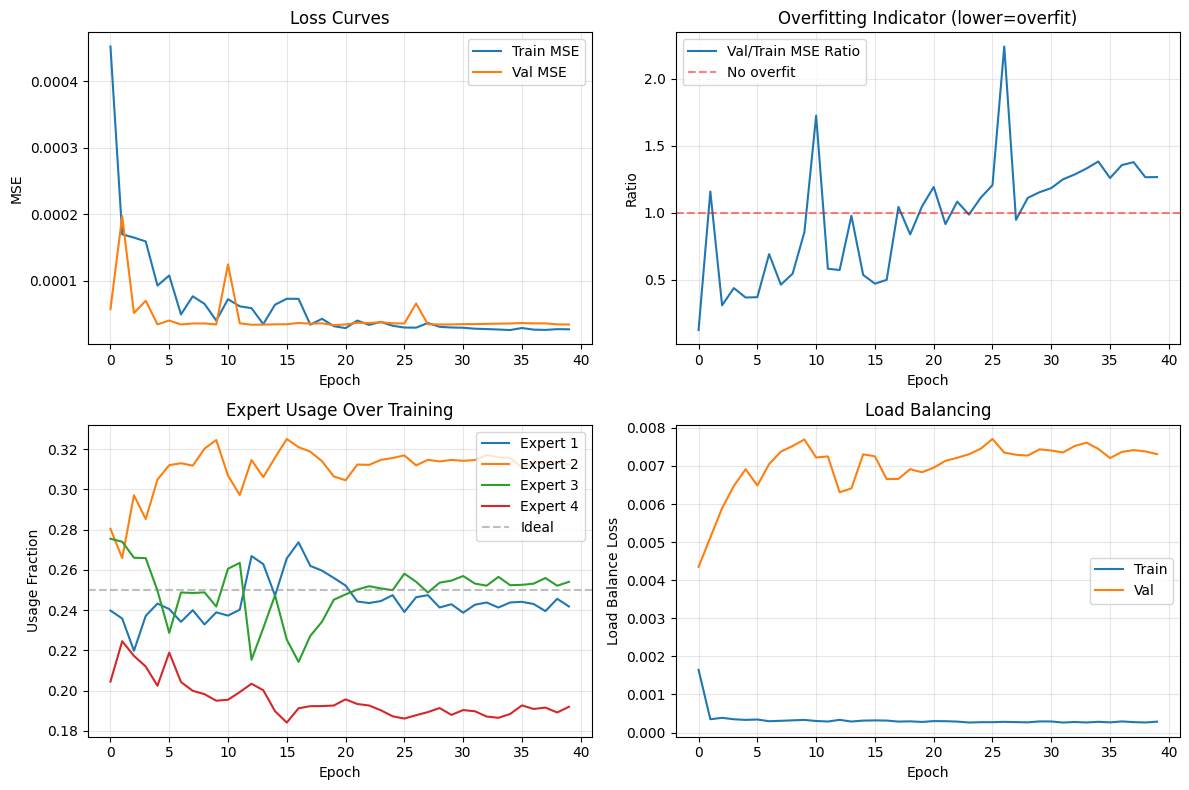

In [241]:
# Plot training history
plot_training_history(history)

In [ ]:
# Final evaluation on test set
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

test_metrics = trainer.evaluate(test_loader)

# --- σ-persistence baseline ---
sigma_pred_test = sigma_persistence_delta(meta_test)
sigma_m = metrics(y_test, sigma_pred_test, sample_weight=w_test)

print("\n" + "-"*60)
print("σ-PERSISTENCE BASELINE (uses TRUE T_{t+h})")
print("-"*60)
print(f"Sigma baseline MAE  : {sigma_m['mae']:.6f}")
print(f"Sigma baseline RMSE : {sigma_m['rmse']:.6f}")
print(f"Sigma baseline wMAE : {sigma_m['w_mae']:.6f}")
print(f"Sigma baseline wRMSE: {sigma_m['w_rmse']:.6f}")

# Model skill vs sigma-persistence (unweighted MAE)
skill_vs_sigma = 1.0 - (test_metrics['mae'] / sigma_m['mae'])
print(f"\nSkill vs σ-persistence (MAE): {skill_vs_sigma:.3f}")

print(f"\nTest MSE: {test_metrics['mse']:.6f}")
print(f"Test MAE: {test_metrics['mae']:.6f}")
print(f"Test RMSE: {test_metrics['rmse']:.6f}")
print(f"Skill vs Naive: {test_metrics['skill_vs_naive']:.3f}")
print(f"Expert Usage: {[f'{u:.2f}' for u in test_metrics['expert_usage']]}")


# Convert variance metrics to IV-equivalent for intuition
mean_iv = df['ATM_IV'].mean()  
mean_T = df['T'].mean()
implied_iv_mae = test_metrics['mae'] / (2 * mean_iv * mean_T)

print(f"\n{'='*60}")
print(f"INTERPRETATION IN IV TERMS")
print(f"{'='*60}")
print(f"MAE (variance): {test_metrics['mae']:.6f}")
print(f"Approximate IV-equivalent: {implied_iv_mae:.4f} ({implied_iv_mae*100:.2f}%)")
print(f"  (Derived using mean IV={mean_iv:.3f}, mean T={mean_T:.3f})")


TEST SET EVALUATION

------------------------------------------------------------
σ-PERSISTENCE BASELINE (uses TRUE T_{t+h})
------------------------------------------------------------
Sigma baseline MAE  : 0.003215
Sigma baseline RMSE : 0.005715
Sigma baseline wMAE : 0.003092
Sigma baseline wRMSE: 0.005495

Skill vs σ-persistence (MAE): 0.077

Test MSE: 0.000022
Test MAE: 0.002967
Test RMSE: 0.004786
Skill vs Naive: 0.137
Expert Usage: ['0.25', '0.26', '0.25', '0.25']

INTERPRETATION IN IV TERMS
MAE (variance): 0.002967
Approximate IV-equivalent: 0.0583 (5.83%)
  (Derived using mean IV=0.293, mean T=0.087)


In [243]:
print(f"Direction Accuracy: {test_metrics['direction_accuracy']:.3f}")  # ADD THIS

Direction Accuracy: 0.639


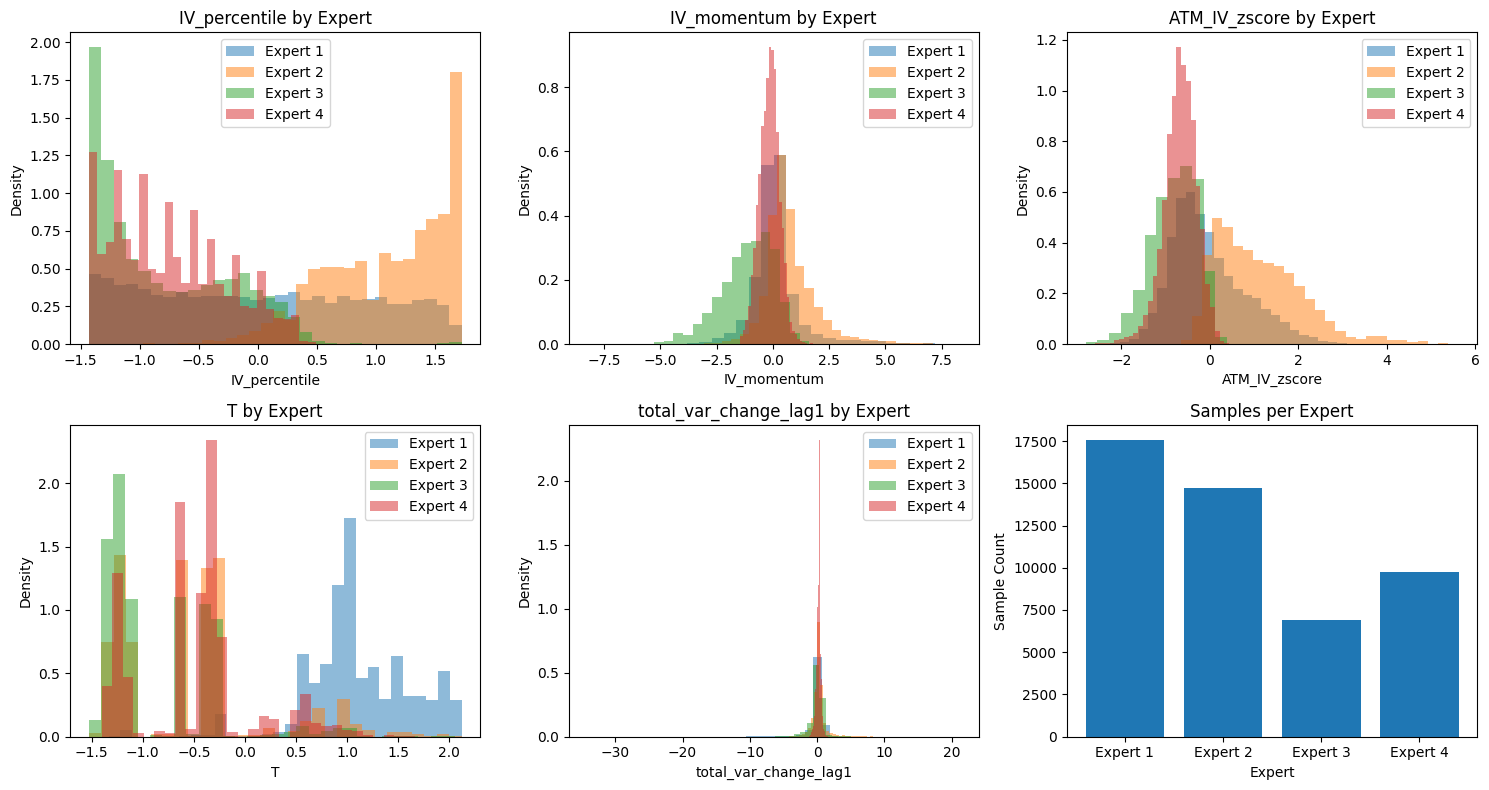


EXPERT SPECIALIZATION ANALYSIS

Expert 1 (17585 samples, 36.0%):
  IV_percentile       : +0.012 ± 0.926
  IV_momentum         : +0.104 ± 1.092
  ATM_IV_zscore       : -0.037 ± 0.841
  T                   : +1.123 ± 0.507
  total_var_change_lag1: -0.007 ± 1.290

Expert 2 (14712 samples, 30.1%):
  IV_percentile       : +1.096 ± 0.519
  IV_momentum         : +0.778 ± 1.177
  ATM_IV_zscore       : +1.121 ± 0.987
  T                   : -0.546 ± 0.695
  total_var_change_lag1: +0.286 ± 0.985

Expert 3 (6880 samples, 14.1%):
  IV_percentile       : -0.811 ± 0.567
  IV_momentum         : -1.139 ± 1.204
  ATM_IV_zscore       : -0.792 ± 0.550
  T                   : -0.855 ± 0.549
  total_var_change_lag1: -0.074 ± 1.013

Expert 4 (9725 samples, 19.9%):
  IV_percentile       : -0.754 ± 0.475
  IV_momentum         : -0.153 ± 0.444
  ATM_IV_zscore       : -0.671 ± 0.376
  T                   : -0.469 ± 0.550
  total_var_change_lag1: +0.234 ± 0.312


In [244]:
# Analyze expert specialization
analyze_expert_specialization(model, test_loader, meta_test, device)

FEATURE-TARGET ALIGNMENT ANALYSIS


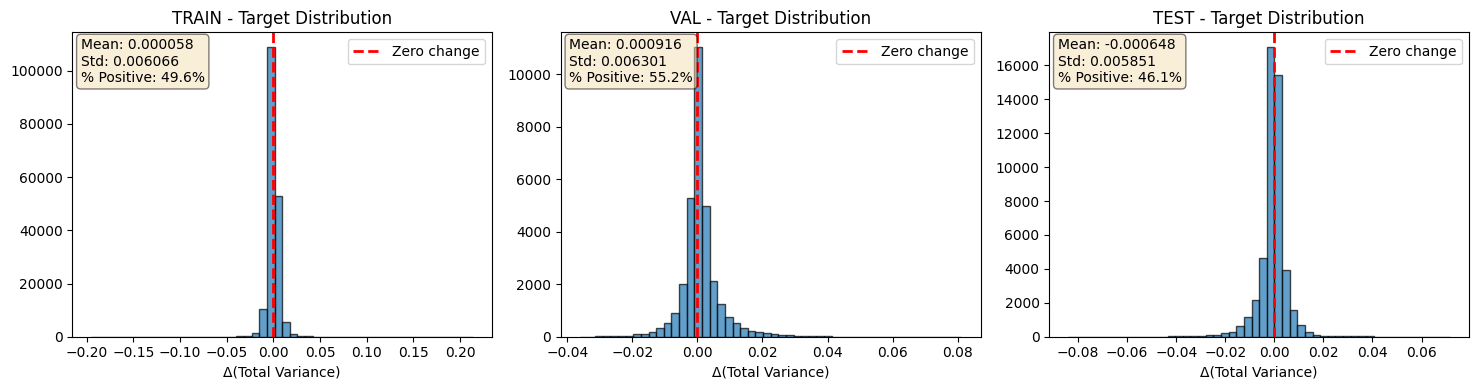


FEATURE STATISTICS BY SPLIT

ATM_IV:
  train: mean=+0.2919, std=0.1073
  val  : mean=+0.2883, std=0.1078
  test : mean=+0.3032, std=0.1197

ATM_skew:
  train: mean=-0.3393, std=0.8927
  val  : mean=-0.3300, std=0.7103
  test : mean=-0.3329, std=0.8181

ATM_curvature:
  train: mean=+6.1011, std=66.5522
  val  : mean=+5.9720, std=72.4697
  test : mean=+7.0161, std=72.8972

T:
  train: mean=+0.0944, std=0.0420
  val  : mean=+0.0956, std=0.0429
  test : mean=+0.0955, std=0.0426

total_var:
  train: mean=+0.0092, std=0.0085
  val  : mean=+0.0090, std=0.0086
  test : mean=+0.0101, std=0.0103

IV_percentile:
  train: mean=+0.4457, std=0.3114
  val  : mean=+0.5634, std=0.3031
  test : mean=+0.4676, std=0.3178

IV_momentum:
  train: mean=-0.0067, std=0.0478
  val  : mean=+0.0020, std=0.0478
  test : mean=-0.0029, std=0.0577

IV_acceleration:
  train: mean=+0.0052, std=0.0543
  val  : mean=+0.0009, std=0.0483
  test : mean=+0.0024, std=0.0634

skew_percentile:
  train: mean=+0.4936, std=0.3047


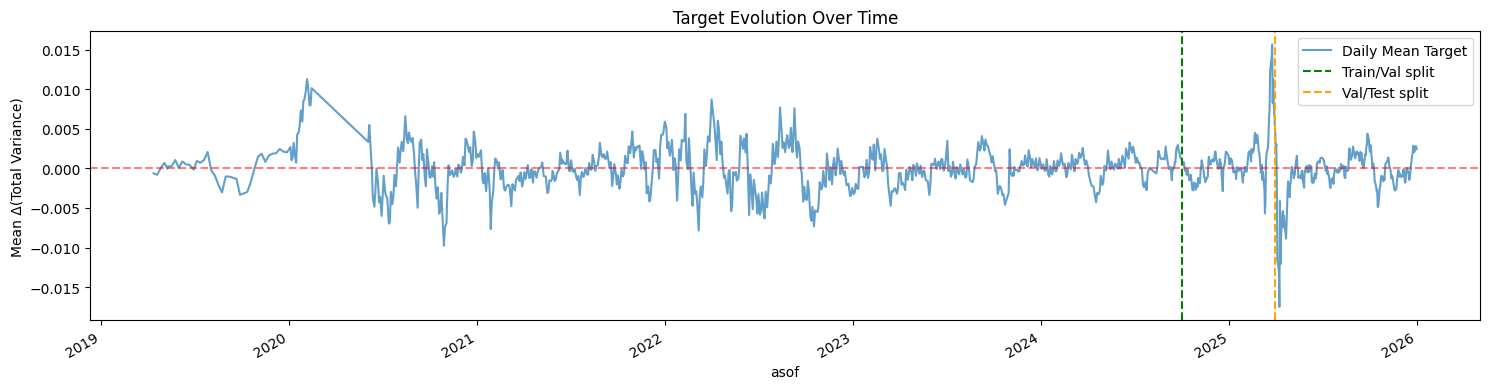

In [ ]:
# DEEP DATA ANALYSIS - FEATURE/TARGET ALIGNMENT

import matplotlib.pyplot as plt
import seaborn as sns

# Combine all data with split labels
meta['split'] = 'train'
meta.loc[meta['asof'] > pd.Timestamp(config.train_end), 'split'] = 'val'
meta.loc[meta['asof'] > pd.Timestamp(config.val_end), 'split'] = 'test'

# Add features and targets for analysis
for i, col in enumerate(config.feature_cols):
    meta[col] = X[:, -1, i]  # Last timestep features
meta['target'] = y

print("="*80)
print("FEATURE-TARGET ALIGNMENT ANALYSIS")
print("="*80)

# 1. Target distribution by split
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, split in enumerate(['train', 'val', 'test']):
    split_data = meta[meta['split'] == split]

    axes[idx].hist(split_data['target'], bins=50, alpha=0.7, edgecolor='black')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero change')
    axes[idx].set_title(f'{split.upper()} - Target Distribution')
    axes[idx].set_xlabel('Δ(Total Variance)')
    axes[idx].legend()

    # Stats
    mean_target = split_data['target'].mean()
    std_target = split_data['target'].std()
    pct_positive = (split_data['target'] > 0).mean() * 100

    axes[idx].text(0.02, 0.98,
                   f'Mean: {mean_target:.6f}\nStd: {std_target:.6f}\n% Positive: {pct_positive:.1f}%',
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# 2. Feature distributions by split
print("\n" + "="*80)
print("FEATURE STATISTICS BY SPLIT")
print("="*80)

for col in config.feature_cols:
    print(f"\n{col}:")
    for split in ['train', 'val', 'test']:
        split_data = meta[meta['split'] == split]
        mean_val = split_data[col].mean()
        std_val = split_data[col].std()
        print(f"  {split:5s}: mean={mean_val:+.4f}, std={std_val:.4f}")

# 3. Correlation between features and target by split
print("\n" + "="*80)
print("FEATURE-TARGET CORRELATIONS BY SPLIT")
print("="*80)

correlations = {}
for split in ['train', 'val', 'test']:
    split_data = meta[meta['split'] == split]
    corrs = {}
    for col in config.feature_cols:
        corr = split_data[[col, 'target']].corr().iloc[0, 1]
        corrs[col] = corr
    correlations[split] = corrs

# Print as table
print(f"\n{'Feature':<20} {'Train':>10} {'Val':>10} {'Test':>10} {'Δ(Train-Test)':>15}")
print("-" * 75)
for col in config.feature_cols:
    train_corr = correlations['train'][col]
    val_corr = correlations['val'][col]
    test_corr = correlations['test'][col]
    delta = train_corr - test_corr

    flag = "⚠️" if abs(delta) > 0.1 else ""
    print(f"{col:<20} {train_corr:>10.3f} {val_corr:>10.3f} {test_corr:>10.3f} {delta:>15.3f} {flag}")

# 4. Target predictability analysis
print("\n" + "="*80)
print("TARGET PREDICTABILITY (Autocorrelation)")
print("="*80)

from statsmodels.tsa.stattools import acf

for split in ['train', 'val', 'test']:
    split_data = meta[meta['split'] == split].sort_values('asof')

    # Autocorrelation of target at different lags
    target_series = split_data['target'].values
    autocorr = acf(target_series, nlags=10, fft=True)

    print(f"\n{split.upper()} autocorrelation (lag 1-5):")
    print(f"  {autocorr[1:6]}")

# 5. Regime distribution
print("\n" + "="*80)
print("REGIME DISTRIBUTION (based on gating features)")
print("="*80)

# Define regimes based on IV_percentile
meta['regime'] = pd.cut(meta['IV_percentile'],
                        bins=[-np.inf, -0.5, 0.5, np.inf],
                        labels=['Low Vol', 'Normal Vol', 'High Vol'])

regime_dist = meta.groupby(['split', 'regime']).size().unstack(fill_value=0)
regime_dist_pct = regime_dist.div(regime_dist.sum(axis=1), axis=0) * 100

print("\nRegime distribution (%):")
print(regime_dist_pct)

# 6. Check for feature-target temporal alignment
print("\n" + "="*80)
print("TEMPORAL ALIGNMENT CHECK")
print("="*80)

# Group by date and check if target variance is consistent
daily_stats = meta.groupby('asof').agg({
    'target': ['mean', 'std', 'count'],
    'ATM_IV': 'mean',
    'T': 'mean'
})

print(f"\nAverage sequences per date: {daily_stats['target']['count'].mean():.1f}")
print(f"Target std across dates: {daily_stats['target']['mean'].std():.6f}")
print(f"Is target mean stable over time? {daily_stats['target']['mean'].std() < 0.001}")

# Plot target evolution over time
fig, ax = plt.subplots(figsize=(15, 4))
daily_stats['target']['mean'].plot(ax=ax, label='Daily Mean Target', alpha=0.7)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.axvline(pd.Timestamp(config.train_end), color='green', linestyle='--', label='Train/Val split')
ax.axvline(pd.Timestamp(config.val_end), color='orange', linestyle='--', label='Val/Test split')
ax.set_ylabel('Mean Δ(Total Variance)')
ax.set_title('Target Evolution Over Time')
ax.legend()
plt.tight_layout()
plt.show()

## 10. Save Model

In [246]:
# Save model and config
save_dict = {
    'model_state_dict': model.state_dict(),
    'config': config.__dict__,
    'normalizer': {
        'mean': normalizer.mean,
        'std': normalizer.std,
        'gate_mean': normalizer.gate_mean,
        'gate_std': normalizer.gate_std
    },
    'history': history,
    'test_metrics': test_metrics
}

torch.save(save_dict, 'moe_iv_forecaster.pt')
print("Model saved to moe_iv_forecaster.pt")

Model saved to moe_iv_forecaster.pt
